In [86]:
import mediapipe as mp
import matplotlib.pyplot as plt
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
from mediapipe.tasks.python.components.containers import NormalizedLandmark
from rembg import remove
from PIL import Image
import numpy as np

## Parameters

In [87]:
mediapipe_model_path = '../hand_landmarker.task'
mediapipe_gesture_recognizer_model_path = '../gesture_recognizer.task'
RGB_image_directory = '../../resources/evaluation_dataset/RGB'
RGB_ground_truth_directory = '../../resources/evaluation_dataset/RGB_annotation'
IR_image_directory = '../../resources/evaluation_dataset/IR'
IR_ground_truth_directory = '../../resources/evaluation_dataset/IR_annotations'
bad_score_penalty = 1
distance_threshold = 0.05

## Create Models

In [88]:
base_options = python.BaseOptions(model_asset_path=mediapipe_gesture_recognizer_model_path)
options = vision.GestureRecognizerOptions(base_options=base_options,
                                          num_hands=2)

options.canned_gesture_classifier_options.score_threshold = 0
gesture_recognizer = vision.GestureRecognizer.create_from_options(options)

## Drawing Landmarks

In [89]:
MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"{handedness[0].category_name}",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

In [90]:
MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image_from_json(rgb_image, evaluation_result):
  hand_landmarks_list = evaluation_result['landmarks']
  # handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    # handedness = handedness_list[idx]
    height, width, _ = annotated_image.shape
    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=float(landmark['x']), y=float(landmark['y']), z=0.0) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
   
    x_coordinates = [landmark['x'] for landmark in hand_landmarks]
    y_coordinates = [landmark['y'] for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"Left",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

## Assessing the Accuracy

In [91]:
def calculate_accuracy(ground_truth, prediction, threshold):
    if prediction is None:  # Missing landmark
        return 0.0
    distance = np.sqrt((float(ground_truth["x"]) - prediction.x) ** 2 + 
                       (float(ground_truth["y"]) - prediction.y) ** 2)
    return max(0, 1 - distance / threshold) * 100

In [92]:
from itertools import permutations

def calculate_hand_accuracies(ground_truth_hands, predicted_hands, handedness_info, threshold):
    accuracies = {"Left": [], "Right": []}

    # If no hands detected, accuracy is 0% for both hands
    if len(predicted_hands) == 0:
        return {"Left": [0.0]*21, "Right": [0.0]*21}
    

    first_predicted_hand = predicted_hands[0]

    hand_accuracy_1 = [
        calculate_accuracy(gt_landmark, pred_landmark, threshold)
        for gt_landmark, pred_landmark in zip(ground_truth_hands[0], first_predicted_hand)
    ]

    hand_accuracy_2 = [
        calculate_accuracy(gt_landmark, pred_landmark, threshold)
        for gt_landmark, pred_landmark in zip(ground_truth_hands[1], first_predicted_hand)
    ]

    if len(predicted_hands) == 1 and sum(hand_accuracy_1) > sum(hand_accuracy_2):
        accuracies["Left"] = hand_accuracy_1
        accuracies["Right"] = [0.0]*21
        return accuracies
    elif len(predicted_hands) == 1:
        accuracies["Right"] = hand_accuracy_2
        accuracies["Left"] = [0.0]*21
        return accuracies
    else:
        second_predicted_hand = predicted_hands[1]
        hand_accuracy_3 = [
            calculate_accuracy(gt_landmark, pred_landmark, threshold)
            for gt_landmark, pred_landmark in zip(ground_truth_hands[0], second_predicted_hand)
        ]

        hand_accuracy_4 = [
            calculate_accuracy(gt_landmark, pred_landmark, threshold)
            for gt_landmark, pred_landmark in zip(ground_truth_hands[1], second_predicted_hand)
        ]

        if sum(hand_accuracy_1) + sum(hand_accuracy_4) > sum(hand_accuracy_2) + sum(hand_accuracy_3):
            accuracies["Left"] = hand_accuracy_1
            accuracies["Right"] = hand_accuracy_4
        else:
            accuracies["Right"] = hand_accuracy_2
            accuracies["Left"] = hand_accuracy_3

    return accuracies

In [93]:
def assess_accuracy(image_path, ground_truth_hands):
    """
    Assess accuracy of predictions for a given image.
    """
    image = mp.Image.create_from_file(image_path)
    
    results = gesture_recognizer.recognize(image)
    
    if not results.hand_landmarks or len(results.hand_landmarks) == 0:
        print(f"No hands detected for {image_path}")
        return {"Left": [0.0]*21, "Right": [0.0]*21}

    return calculate_hand_accuracies(
        ground_truth_hands,
        results.hand_landmarks,
        results.handedness,
        distance_threshold
    )

## Calculating Distance and Average Sum of Distance for the Dataset

In [94]:
def calculate_euclidean_distance(ground_truth, prediction):
    distance = np.sqrt((float(ground_truth["x"]) - prediction.x) ** 2 + 
                       (float(ground_truth["y"]) - prediction.y) ** 2)
    return distance

In [95]:
def calculate_sum_of_distances(ground_truth_hands, predicted_hands):
    distances = {"Left": [], "Right": []}
    if len(predicted_hands) == 0:
        return sum([bad_score_penalty*21]) + sum([bad_score_penalty*21])
    
    if len(predicted_hands) == 1:
        print("Only one hand detected")

    first_predicted_hand = predicted_hands[0]

    hand_distances_1 = [
        calculate_euclidean_distance(gt_landmark, pred_landmark)
        for gt_landmark, pred_landmark in zip(ground_truth_hands[0], first_predicted_hand)
    ]

    hand_distances_2 = [
        calculate_euclidean_distance(gt_landmark, pred_landmark)
        for gt_landmark, pred_landmark in zip(ground_truth_hands[1], first_predicted_hand)
    ]

    if len(predicted_hands) == 1 and sum(hand_distances_1) < sum(hand_distances_2):
        distances["Left"] = sum(hand_distances_1)
        distances["Right"] = sum([bad_score_penalty*21])
    elif len(predicted_hands) == 1:
        distances["Right"] = sum(hand_distances_2)
        distances["Left"] = sum([bad_score_penalty*21])
    else:
        second_predicted_hand = predicted_hands[1]
        hand_distances_3 = [
            calculate_euclidean_distance(gt_landmark, pred_landmark)
            for gt_landmark, pred_landmark in zip(ground_truth_hands[0], second_predicted_hand)
        ]

        hand_distances_4 = [
            calculate_euclidean_distance(gt_landmark, pred_landmark)
            for gt_landmark, pred_landmark in zip(ground_truth_hands[1], second_predicted_hand)
        ]

        if sum(hand_distances_1) + sum(hand_distances_4) < sum(hand_distances_2) + sum(hand_distances_3):
            distances["Left"] = sum(hand_distances_1)
            distances["Right"] = sum(hand_distances_4)
        else:
            distances["Right"] = sum(hand_distances_2)
            distances["Left"] = sum(hand_distances_3)
            
    

    return distances["Left"] + distances["Right"]

In [96]:
def calculate_sum_of_distances_for_image(image_path, ground_truth_hands):
    image = mp.Image.create_from_file(image_path)
    results = gesture_recognizer.recognize(image)
    distance = calculate_sum_of_distances(ground_truth_hands, results.hand_landmarks)
    
    return distance

In [97]:
def calculate_distances(ground_truth_hands, predicted_hands):
    distances = {"Left": [], "Right": []}
    if len(predicted_hands) == 0:
        return {"Left": [bad_score_penalty] * 21, "Right": [bad_score_penalty] * 21 }
    
    if len(predicted_hands) == 1:
        print("Only one hand detected")

    first_predicted_hand = predicted_hands[0]

    hand_distances_1 = [
        calculate_euclidean_distance(gt_landmark, pred_landmark)
        for gt_landmark, pred_landmark in zip(ground_truth_hands[0], first_predicted_hand)
    ]

    hand_distances_2 = [
        calculate_euclidean_distance(gt_landmark, pred_landmark)
        for gt_landmark, pred_landmark in zip(ground_truth_hands[1], first_predicted_hand)
    ]

    if len(predicted_hands) == 1 and sum(hand_distances_1) < sum(hand_distances_2):
        distances["Left"] = hand_distances_1
        distances["Right"] = [bad_score_penalty] * 21
    elif len(predicted_hands) == 1:
        distances["Right"] = hand_distances_2
        distances["Left"] = [bad_score_penalty] * 21
    else:
        second_predicted_hand = predicted_hands[1]
        hand_distances_3 = [
            calculate_euclidean_distance(gt_landmark, pred_landmark)
            for gt_landmark, pred_landmark in zip(ground_truth_hands[0], second_predicted_hand)
        ]

        hand_distances_4 = [
            calculate_euclidean_distance(gt_landmark, pred_landmark)
            for gt_landmark, pred_landmark in zip(ground_truth_hands[1], second_predicted_hand)
        ]

        if sum(hand_distances_1) + sum(hand_distances_4) < sum(hand_distances_2) + sum(hand_distances_3):
            distances["Left"] = hand_distances_1
            distances["Right"] = hand_distances_4
        else:
            distances["Right"] = hand_distances_2
            distances["Left"] = hand_distances_3
            
    return distances

In [98]:
def calculate_avg_distance_for_image(image_path, ground_truth_hands):
    image = mp.Image.create_from_file(image_path)
    results = gesture_recognizer.recognize(image)
    distances = calculate_distances(ground_truth_hands, results.hand_landmarks)
    
    return sum(distances["Left"] + distances["Right"]) / len(distances["Left"] + distances["Right"])

In [99]:
def calculate_distances_for_image(image_path, ground_truth_hands):
    image = mp.Image.create_from_file(image_path)
    results = gesture_recognizer.recognize(image)
    distances = calculate_distances(ground_truth_hands, results.hand_landmarks)
    
    return distances["Left"] + distances["Right"]

## Creating Thresholds/Bounds


In [100]:
def calculate_final_accuracy(scores):
    all_scores = scores["Left"] + scores["Right"]
    return sum(all_scores) / len(all_scores) if all_scores else 0.0

In [101]:
import os
import json

def calculate_bound_accuracy(image_directory, ground_truth_directory):
    total_bound = {"Left": [], "Right":[]}
    for file_name in os.listdir(ground_truth_directory):
        if file_name.endswith('.json'):
            json_file_path = os.path.join(ground_truth_directory, file_name)
            
            with open(json_file_path, 'r') as f:
                ground_truth_data = json.load(f)
                
            for entry in ground_truth_data:
                image_name = entry["image"]
                ground_truth_landmarks = entry["landmarks"]
                image_path = os.path.join(image_directory, image_name)
    
                # Assess accuracy for RGB images (upper bound)
                score = assess_accuracy(image_path, ground_truth_landmarks)
                
                for hand in ["Left", "Right"]:
                    total_bound[hand].extend(score[hand])
    return calculate_final_accuracy(total_bound)
    

In [102]:
upper_bound_accuracy = calculate_bound_accuracy(RGB_image_directory, RGB_ground_truth_directory)
lower_bound_accuracy = calculate_bound_accuracy(IR_image_directory ,IR_ground_truth_directory)

No hands detected for ../../resources/evaluation_dataset/IR\3_IMG20241127100408.jpg
No hands detected for ../../resources/evaluation_dataset/IR\5_IMG20241127100507.jpg
No hands detected for ../../resources/evaluation_dataset/IR\6_IMG20241127100515.jpg
No hands detected for ../../resources/evaluation_dataset/IR\10_IMG20241127100740.jpg
No hands detected for ../../resources/evaluation_dataset/IR\11_IMG20241127100906.jpg
No hands detected for ../../resources/evaluation_dataset/IR\12_IMG20241127100913.jpg
No hands detected for ../../resources/evaluation_dataset/IR\13_IMG20241127101012.jpg
No hands detected for ../../resources/evaluation_dataset/IR\14_IMG20241127101019.jpg
No hands detected for ../../resources/evaluation_dataset/IR\29_IMG20241127102051.jpg
No hands detected for ../../resources/evaluation_dataset/IR\38_IMG20241127102643.jpg
No hands detected for ../../resources/evaluation_dataset/IR\39_IMG20241127102649.jpg
No hands detected for ../../resources/evaluation_dataset/IR\40_IMG20

In [103]:
print(f"Upper Bound Accuracy (RGB): {upper_bound_accuracy:.2f}%")
print(f"Lower Bound Accuracy (Infrared): {lower_bound_accuracy:.2f}%")

Upper Bound Accuracy (RGB): 84.26%
Lower Bound Accuracy (Infrared): 42.29%


## Visualizing Thresholds

In [104]:
def visualize_threshold_roi(image_path, ground_truth_landmarks, threshold, output_path):
    """
    Visualizes regions of interest (ROIs) based on the threshold for accuracy.

    Parameters:
        image_path (str): Path to the image file.
        ground_truth_landmarks (list of dict): Ground truth landmarks with 'x' and 'y' coordinates.
        threshold (float): Distance threshold for accuracy calculation.
        output_path (str): Path to save the output visualization image.
    """
    # Load the image
    image = cv2.imread(image_path)
    overlay = image.copy()

    height, width, _ = image.shape

    # Draw circles around the ground truth landmarks
    for hand in ground_truth_landmarks:
        for landmark in hand:
            center = (int(float(landmark['x']) * width), int(float(landmark['y']) * height))
            radius = int(threshold*width)  # Scale threshold to image dimensions
            color = (0, 255, 0)  # Green color for the circle
            alpha = 0.4  # Transparency factor
    
            # Draw the circle on the overlay
            cv2.circle(overlay, center, radius, color, -1)

    # Blend the overlay with the original image
    cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0, image)

    # Save the output image
    cv2.imwrite(output_path, image)

## Transforming Images

In [105]:
import sys
sys.path.append('../')
sys.path.append('../colorization/zhang')

In [106]:
from src.colorization.Zhang import create_colorized_pictures
def colorize_zhang_eccv16(image_path, image_name):
    create_colorized_pictures(model='eccv16', img_path=image_path, save_prefix=image_name)  
    return f'../../resources/stylized-pictures/eccv16/{image_name}_eccv16.png'

In [107]:
def colorize_zhang_siggraph17(image_path, image_name):
    create_colorized_pictures(model='siggraph17', img_path=image_path, save_prefix=image_name)  
    return f'../../resources/stylized-pictures/siggraph17/{image_name}_siggraph17.png'
    

In [108]:
def clahe(image, clipLimit=2.0, tileGridSize=(8, 8), save_path=None, save_as_rgb=True):
    """
    Applies Contrast Limited Adaptive Histogram Equalization (CLAHE) to an image.
    
    Parameters:
    - image: Input image (grayscale or BGR/RGB).
    - clipLimit: Threshold for contrast limiting.
    - tileGridSize: Size of the grid for histogram equalization.
    - save_path: Path to save the output image.
    - save_as_rgb: Save the CLAHE-applied image in RGB format if True.
    
    Returns:
    - Processed image in grayscale or RGB format.
    """
    # Convert to grayscale if it's a color image
    if len(image.shape) == 3:  # If RGB/BGR
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    clahe_image = clahe.apply(gray)

    # Convert back to RGB if required
    if save_as_rgb:
        clahe_image_rgb = cv2.cvtColor(clahe_image, cv2.COLOR_GRAY2RGB)
    else:
        clahe_image_rgb = clahe_image

    # Save the image if a save_path is provided
    if save_path:
        cv2.imwrite(save_path, clahe_image_rgb if save_as_rgb else clahe_image)
        print(f"CLAHE-applied image saved at {save_path}")

    return clahe_image_rgb if save_as_rgb else clahe_image


In [109]:
def reduce_brightness(image_path, save_path, reduction_factor=0.5):
    """
    Reads an image, reduces its brightness, and saves the result.
    
    Parameters:
    - image_path: Path to the input image.
    - save_path: Path to save the output image.
    - reduction_factor: Factor by which to reduce brightness (0.0 to 1.0, where 1.0 is no change).
    
    Returns:
    - The brightness-reduced image as a NumPy array.
    """
    # Read the image
    image = cv2.imread(image_path)

    if image is None:
        raise ValueError(f"Image at path {image_path} could not be loaded.")

    # Convert to float to avoid clipping during multiplication
    image = image.astype(np.float32)

    # Reduce brightness
    brightness_reduced = np.clip(image * reduction_factor, 0, 255).astype(np.uint8)

    # Save the result
    cv2.imwrite(save_path, brightness_reduced)
    print(f"Brightness-reduced image saved at {save_path}")

    return brightness_reduced


In [110]:
def remove_background(image_path, save_path):
    # Processing the image 
    input = Image.open(image_path)
    
    # Removing the background from the given Image 
    output = remove(input)
    
    # Saving the image in the given path
    output.save(save_path)

In [111]:
def gaussian_smoothing(image, kernel_size=(5, 5), sigma=0):
    """
    Applies Gaussian smoothing to an image.
    
    Parameters:
    - image: Input image (grayscale or BGR/RGB).
    - kernel_size: Size of the Gaussian kernel (height, width).
    - sigma: Standard deviation of the Gaussian distribution.
    
    Returns:
    - Smoothed image.
    """
    image = cv2.imread(f"../../resources/stylized-pictures/no_background/{image_name}_background_removed.png")
    # Apply median blur
    median_blur = cv2.medianBlur(image, 5)
    #smoothed = cv2.GaussianBlur(image, kernel_size, sigma)
    # Save the smoothed image
    cv2.imwrite(f"../../resources/stylized-pictures/no_background/smoothed/{image_name}_smoothed.png", median_blur)
    return f"../../resources/stylized-pictures/no_background/smoothed/{image_name}_smoothed.png"
    

In [112]:
import cv2
import numpy as np

def remove_temperature_boxes(image_path, image_name):
    # Load the image using OpenCV
    image_cv = cv2.imread(image_path)

    # Convert to HSV to target specific colors (red and green boxes)
    hsv_image = cv2.cvtColor(image_cv, cv2.COLOR_BGR2HSV)

    # Define color ranges for red and green (in HSV space)
    lower_red1 = np.array([0, 120, 70])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 120, 70])
    upper_red2 = np.array([180, 255, 255])
    lower_green = np.array([35, 100, 100])
    upper_green = np.array([85, 255, 255])

    # Create masks for red and green
    mask_red1 = cv2.inRange(hsv_image, lower_red1, upper_red1)
    mask_red2 = cv2.inRange(hsv_image, lower_red2, upper_red2)
    mask_green = cv2.inRange(hsv_image, lower_green, upper_green)
    mask_red = mask_red1 | mask_red2

    # Combine masks for both colors
    mask_combined = mask_red | mask_green

    # Dilate the mask slightly to cover edges of the red and green regions
    kernel = np.ones((5, 5), np.uint8)
    dilated_mask = cv2.dilate(mask_combined, kernel, iterations=1)

    # Inpaint to remove red and green regions
    image_no_boxes = cv2.inpaint(image_cv, dilated_mask, inpaintRadius=5, flags=cv2.INPAINT_TELEA)

    # Apply Gaussian blur to smooth the entire image
    smoothed_image = cv2.GaussianBlur(image_no_boxes, (5, 5), 0)

    # Save the final image
    smoothed_output_path = f"../../resources/stylized-pictures/no_boxes/{image_name}_no_boxes.png"
    cv2.imwrite(smoothed_output_path, smoothed_image)

    return smoothed_output_path



In [113]:
def mask_temperature_scale(image_path, output_path):
    """
    Masks the temperature scale on the left side of the image
    by replacing it with the average background color.
    """
    # Load the image
    image = cv2.imread(image_path)

    # Define the regions to mask
    scale_width = 210  # Width of the scale region on the left
    temp_box_width = 260  # Width of the temperature box in the top-right
    temp_box_height = 90  # Height of the temperature box in the top-right

    # Mask the left temperature scale
    scale_region = image[:, :scale_width]
    avg_color_scale = np.mean(image[:, scale_width:], axis=(0, 1), dtype=int)
    image[:, :scale_width] = avg_color_scale

    # Mask the temperature box in the upper-right corner
    temp_box_region = image[:temp_box_height, -temp_box_width:]
    avg_color_temp_box = np.mean(image[temp_box_height:, :-temp_box_width], axis=(0, 1), dtype=int)
    image[:temp_box_height, -temp_box_width:] = avg_color_temp_box

     # Save the masked image
    cv2.imwrite(output_path, image)

    return output_path

In [114]:
def detect_edges_sobelX(image):
    """Detects edges in an image using the Sobel edge detection algorithm"""
    return cv2.Sobel(image,cv2.CV_64F,1,0,ksize=5)

def detect_edges_sobelY(image):
    """Detects edges in an image using the Sobel edge detection algorithm"""
    return cv2.Sobel(image,cv2.CV_64F,0,1,ksize=5)

In [115]:
def canny_edge_detection(frame): 
    # Convert the frame to grayscale for edge detection 
    # gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
      
    # Apply Gaussian blur to reduce noise and smoothen edges 
    blurred = cv2.GaussianBlur(src=frame, ksize=(3, 5), sigmaX=0.5) 
      
    # Perform Canny edge detection 
    edges = cv2.Canny(blurred, 70, 135) 
      
    return blurred, edges

In [116]:
# Check whether recognized hands are left or right
def is_right_hand(landmarks):
    counter = 0
    
    for landmark in landmarks:
        if landmark.x > 0.5:
            counter += 1
            
    return counter > 10

## Load Data

In [117]:
results = []

## Processing Images

In [118]:
from rembg import remove 
from PIL import Image

In [119]:
def merge_landmarks(first_pipeline, second_pipeline, handedness):
    merged_landmarks = []

    for i in range(len(first_pipeline)):
        first_landmarks = first_pipeline[i]
        second_landmarks = second_pipeline[i]

        if i < 6:
            if handedness == "Left":
                merged_point = first_landmarks if first_landmarks.x < second_landmarks.x else second_landmarks
            else:  # Right
                merged_point = first_landmarks if first_landmarks.x > second_landmarks.x else second_landmarks
        else:
            merged_point = min(first_landmarks, second_landmarks, key=lambda p: p.y)

        merged_landmarks.append(merged_point)

    return merged_landmarks

In [120]:
def remove_cross(image_path, image_name):
    """
    Removes the white cross from the center of an image by creating a mask and applying inpainting.
    """
    # Load the image in color
    image = cv2.imread(image_path)
    
    # Get image dimensions
    h, w = image.shape[:2]
    center_x, center_y = w // 2, h // 2
    
    # Define cross size (adjust as needed)
    cross_size = 50  # Length of the cross arms
    thickness = 10   # Thickness of the lines

    # Create a mask for the cross
    mask = np.zeros((h, w), dtype=np.uint8)
    # Draw horizontal and vertical lines for the cross
    cv2.line(mask, (center_x - cross_size, center_y), (center_x + cross_size, center_y), 255, thickness)
    cv2.line(mask, (center_x, center_y - cross_size), (center_x, center_y + cross_size), 255, thickness)

    # Apply inpainting to remove the cross
    result = cv2.inpaint(image, mask, inpaintRadius=5, flags=cv2.INPAINT_TELEA)
    
    path = f"../../resources/stylized-pictures/no_cross/{image_name}_no_cross.png"
    cv2.imwrite(path, result)
    
    return path


In [121]:
def execute_transformation_pipeline(image_path, image_name, colorization_model='siggraph17'):
    no_boxes_image_path = remove_temperature_boxes(image_path, image_name)
    
    # # Invert the colors
    inverted_image = cv2.bitwise_not(cv2.imread(no_boxes_image_path))
    # Save the inverted image
    inverted_image_path = f"../../resources/stylized-pictures/inverted/{image_name}_inverted.png"
    cv2.imwrite(inverted_image_path, inverted_image)

    
    # Generate colorized image using Zhang model
    transformed_image_path = None

    if colorization_model == 'eccv16':
        transformed_image_path = colorize_zhang_eccv16(inverted_image_path, image_name)
    elif colorization_model == 'siggraph17':
        transformed_image_path = colorize_zhang_siggraph17(inverted_image_path, image_name)
    
    return transformed_image_path
    

In [122]:
def execute_transformation_pipeline_with_no_visible_fingers(image_path, image_name, colorization_model='siggraph17'):
    no_boxes_image_path = remove_temperature_boxes(image_path, image_name)
    # no_cross_path = remove_cross(no_boxes_image_path, image_name)
    
    image = cv2.imread(no_boxes_image_path, cv2.IMREAD_GRAYSCALE)
    
    
    # Step 3: Enhance contrast using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(image)
    
    # Step 4: Sharpen edges to highlight fingers
    kernel = np.array([[-1, -1, -1],
                       [-1,  9, -1],
                       [-1, -1, -1]])
    sharpened_image = cv2.filter2D(enhanced_image, -1, kernel)
    
    # Change the image to RGB format
    sharpened_image = cv2.cvtColor(sharpened_image, cv2.COLOR_GRAY2RGB)
    
    sharpened_image_path = f"../../resources/stylized-pictures/not_detected/sharpened/{image_name}_sharpened.png"
    cv2.imwrite(sharpened_image_path, sharpened_image)
    
    # transformed_image_path = colorize_zhang_siggraph17(sharpened_image_path, image_name)
    
    return sharpened_image_path
    

In [123]:
def two_hands_detected(image_path):
    image = mp.Image.create_from_file(image_path)
    
    results = gesture_recognizer.recognize(image)
    
    if not results.hand_landmarks or len(results.hand_landmarks) < 2:
        return False
    return True

In [124]:
def create_landmarks_from_results(results):
    landmarks = results.hand_landmarks
    final_landmarks = {"Left": [], "Right": []}
    for hand in landmarks:
        if is_right_hand(hand):
            final_landmarks["Right"] = hand
        else:
            final_landmarks["Left"] = hand
    return final_landmarks
    

In [154]:
def annotate_landmarks(image_path, results, output_path):
    try:
        image = cv2.imread(image_path)
        annotated_image = np.copy(image)
        
        for hand in results:
            hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
            hand_landmarks_proto.landmark.extend([
                landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand
            ])
            solutions.drawing_utils.draw_landmarks(
                annotated_image,
                hand_landmarks_proto,
                solutions.hands.HAND_CONNECTIONS,
                solutions.drawing_styles.get_default_hand_landmarks_style(),
                solutions.drawing_styles.get_default_hand_connections_style()
            )
        
        cv2.imwrite(output_path, annotated_image)
    except Exception as e:
        print(f"COULD NOT ANNOTATE LANDMARKS FOR {image_path.upper()}: {str(e).upper()}")


In [155]:
def rotate_landmarks_90_counterclockwise(landmarks):
    rotated_landmarks = []
    for group in landmarks:
        rotated_group = []
        for point in group:
            x, y = point['x'], point['y']
            rotated_group.append({'x': y, 'y': 1 - x})
        rotated_landmarks.append(rotated_group)
    return rotated_landmarks

In [156]:
total_transformed_siggraph17 = {"Left": [], "Right": []}
total_transformed_eccv16 = {"Left": [], "Right": []}

In [157]:
total_distances_siggaph17 = []
total_distances_eccv16 = []

In [158]:
hand_landmarker_first = {"Left": [], "Right": []}
hand_landmarker_second = {"Left": [], "Right": []}

gesture_recognizer_first = {"Left": [], "Right": []}
gesture_recognizer_second = {"Left": [], "Right": []}

In [159]:
def advanced_enhancement(image_path, image_name):
    no_boxes_image_path = remove_temperature_boxes(image_path, image_name)
    no_cross_path = remove_cross(no_boxes_image_path, image_name)
    # Load the image in grayscale
    image = cv2.imread(no_cross_path, cv2.IMREAD_GRAYSCALE)
    # Apply histogram equalization
    equalized = cv2.equalizeHist(image)
    # Invert the colors
    inverted = cv2.bitwise_not(equalized)
    # Apply GaussianBlur to reduce noise and enhance features
    blurred = cv2.GaussianBlur(inverted, (5, 5), 0)
    # Combine equalization and inversion for better contrast
    combined = cv2.addWeighted(equalized, 0.7, blurred, 0.3, 0)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(combined)
    
    # Change the image to RGB format
    # sharpened_image = cv2.cvtColor(sharpened_image, cv2.COLOR_GRAY2RGB)
    # Save the enhanced image
    enhanced_path = f"../../resources/stylized-pictures/enhanced/{image_name}_enhanced.png"
    cv2.imwrite(enhanced_path, cv2.cvtColor(enhanced_image, cv2.COLOR_GRAY2RGB))

    return enhanced_path

In [160]:
class Category:
    def __init__(self, category_name):
        self.category_name = category_name

In [161]:
class Results:
    def __init__(self, hand_landmarks, handedness):
        self.hand_landmarks = hand_landmarks
        self.handedness = handedness

In [162]:
# Process each image
for file_name in os.listdir(IR_ground_truth_directory):
    if file_name.endswith('.json'):
        json_file_path = os.path.join(IR_ground_truth_directory, file_name)
        
        with open(json_file_path, 'r') as f:
            ground_truth_data = json.load(f)
            
        for entry in ground_truth_data:
            image_name = entry["image"]
            ground_truth_landmarks = entry["landmarks"]
            ground_truth_landmarks = rotate_landmarks_90_counterclockwise(ground_truth_landmarks)
            image_path = f"{IR_image_directory}/{image_name}"
            
            image = cv2.imread(image_path)
            rotated = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
            rotated_path = f"../../resources/stylized-pictures/rotated/{image_name}_rotated.png"
            cv2.imwrite(rotated_path, rotated)
            image_path = rotated_path
            
            
            print(f"Processing image: {image_name}")

            first_pipeline_image_path = execute_transformation_pipeline(image_path, image_name)
            first_pipeline_score = assess_accuracy(first_pipeline_image_path, ground_truth_landmarks)
            print(f"Results for original pipeline - Left: {np.mean(first_pipeline_score['Left']):.2f}%, Right: {np.mean(first_pipeline_score['Right']):.2f}%")
            
            second_pipeline_image_path = execute_transformation_pipeline_with_no_visible_fingers(image_path, image_name)
            second_pipeline_score = assess_accuracy(second_pipeline_image_path, ground_truth_landmarks)
            print(f"Results for second pipeline - Left: {np.mean(second_pipeline_score['Left']):.2f}%, Right: {np.mean(second_pipeline_score['Right']):.2f}%")
            
            third_pipeline_image_path = advanced_enhancement(image_path, image_name)
            third_pipeline_score = assess_accuracy(third_pipeline_image_path, ground_truth_landmarks)
            print(f"Results for third pipeline - Left: {np.mean(third_pipeline_score['Left']):.2f}%, Right: {np.mean(third_pipeline_score['Right']):.2f}%")
            
            image = mp.Image.create_from_file(first_pipeline_image_path)
            recognizer_results_first_pipeline = gesture_recognizer.recognize(image)
            landmarks_first_pipeline = create_landmarks_from_results(recognizer_results_first_pipeline)
            
            image = mp.Image.create_from_file(second_pipeline_image_path)
            recognizer_results_second_pipeline = gesture_recognizer.recognize(image)
            landmarks_second_pipeline = create_landmarks_from_results(recognizer_results_second_pipeline)
            
            final_score = first_pipeline_score
            final_landmarks = []
            
            if len(recognizer_results_first_pipeline.gestures) == 2 and len(recognizer_results_second_pipeline.gestures) == 2:
                mapped_indexes = {"Left": 0, "Right": 1}
                for hand in ["Left", "Right"]:
                    index = mapped_indexes[hand]
                    first_pipeline_gesture = recognizer_results_first_pipeline.gestures[index][0]
                    second_pipeline_gesture = recognizer_results_second_pipeline.gestures[index][0]
                    
                    if first_pipeline_gesture.category_name == 'Open_Palm' and second_pipeline_gesture.category_name == 'Open_Palm':
                        # Merge the landmarks
                        print("Both recognized open palm")
                        merged_left_landmarks = merge_landmarks(landmarks_first_pipeline["Left"], landmarks_second_pipeline["Left"], "Left")
                        merged_right_landmarks = merge_landmarks(landmarks_first_pipeline["Right"], landmarks_second_pipeline["Right"], "Right")
                        final_landmarks.append(merged_left_landmarks)
                        final_landmarks.append(merged_right_landmarks)
                        # if first_pipeline_gesture.score > second_pipeline_gesture.score:
                        #     final_score[hand] = first_pipeline_score[hand]
                        #     final_landmarks.append(landmarks_first_pipeline[hand])
                        # else:
                        #     final_score[hand] = second_pipeline_score[hand]
                        #     final_landmarks.append(landmarks_second_pipeline[hand])
                        
                    elif first_pipeline_gesture.category_name == 'Open_Palm':
                        print("First recognized open palm")
                        final_score[hand] = first_pipeline_score[hand]
                        final_landmarks.append(landmarks_first_pipeline[hand])
                    elif second_pipeline_gesture.category_name == 'Open_Palm':
                        print("Second recognized open palm")
                        final_score[hand] = second_pipeline_score[hand]
                        final_landmarks.append(landmarks_second_pipeline[hand])
                    else:
                        print("Neither recognized open palm")
                        if first_pipeline_gesture.score < second_pipeline_gesture.score:
                            final_score[hand] = first_pipeline_score[hand]
                            final_landmarks.append(landmarks_first_pipeline[hand])
                        else:
                            final_score = second_pipeline_score
                            final_landmarks.append(landmarks_second_pipeline[hand])
                        
            if len(recognizer_results_first_pipeline.gestures) == 2 and len(recognizer_results_second_pipeline.gestures) == 1:
                second_pipeline_handedness = "Right" if is_right_hand(recognizer_results_second_pipeline.hand_landmarks[0]) else "Left"
                complementary_hand = "Right" if second_pipeline_handedness == "Left" else "Left"
                index = 0 if second_pipeline_handedness == "Left" else 1
                first_pipeline_gesture = recognizer_results_first_pipeline.gestures[index][0]
                second_pipeline_gesture = recognizer_results_second_pipeline.gestures[0][0]
                
                if first_pipeline_gesture == 'Open_Palm' and second_pipeline_gesture == 'Open_Palm' and first_pipeline_gesture.score > second_pipeline_gesture.score:
                    final_score = first_pipeline_score
                    final_landmarks.append(landmarks_first_pipeline["Left"])
                    final_landmarks.append(landmarks_first_pipeline["Right"])
                elif first_pipeline_gesture == 'Open_Palm' and second_pipeline_gesture == 'Open_Palm' and first_pipeline_gesture.score < second_pipeline_gesture.score:
                    final_score[second_pipeline_handedness] = second_pipeline_score[second_pipeline_handedness]
                    final_landmarks.append(landmarks_second_pipeline[second_pipeline_handedness])
                    final_landmarks.append(landmarks_first_pipeline[complementary_hand])
                elif first_pipeline_gesture == 'Open_Palm':
                    final_score = first_pipeline_score
                    final_landmarks.append(landmarks_first_pipeline["Left"])
                    final_landmarks.append(landmarks_first_pipeline["Right"])
                elif second_pipeline_gesture == 'Open_Palm':
                    final_score[second_pipeline_handedness] = second_pipeline_score[second_pipeline_handedness]
                    final_landmarks.append(landmarks_second_pipeline[second_pipeline_handedness])
                    final_landmarks.append(landmarks_first_pipeline[complementary_hand])
                else: # None of them are open palm, take the None gesture with less score
                    if first_pipeline_gesture.score < second_pipeline_gesture.score:
                        final_score = first_pipeline_score
                        final_landmarks.append(landmarks_first_pipeline["Left"])
                        final_landmarks.append(landmarks_first_pipeline["Right"])
                    else:
                        final_score[second_pipeline_handedness] = second_pipeline_score[second_pipeline_handedness] 
                        final_landmarks.append(landmarks_second_pipeline[second_pipeline_handedness])
                        final_landmarks.append(landmarks_first_pipeline[complementary_hand])
                
            if len(recognizer_results_first_pipeline.gestures) == 1 and len(recognizer_results_second_pipeline.gestures) == 2:
                first_pipeline_handedness = "Right" if is_right_hand(recognizer_results_first_pipeline.hand_landmarks[0]) else "Left"
                complementary_hand = "Right" if first_pipeline_handedness == "Left" else "Left"
                index = 0 if first_pipeline_handedness == "Left" else 1
                first_pipeline_gesture = recognizer_results_first_pipeline.gestures[0][0]
                second_pipeline_gesture = recognizer_results_second_pipeline.gestures[index][0]
                
                final_score = second_pipeline_score 
                
                if first_pipeline_gesture.category_name == 'Open_Palm' and second_pipeline_gesture.category_name == 'Open_Palm' and first_pipeline_gesture.score > second_pipeline_gesture.score:
                    final_score[first_pipeline_handedness] = first_pipeline_score[first_pipeline_handedness]
                    final_score[complementary_hand] = second_pipeline_score[complementary_hand]
                    final_landmarks.append(landmarks_first_pipeline[first_pipeline_handedness])
                    final_landmarks.append(landmarks_second_pipeline[complementary_hand])
                    
                elif first_pipeline_gesture.category_name == 'Open_Palm' and second_pipeline_gesture.category_name == 'Open_Palm' and first_pipeline_gesture.score < second_pipeline_gesture.score:
                    final_score[first_pipeline_handedness] = second_pipeline_score[first_pipeline_handedness]
                    final_score[complementary_hand] = second_pipeline_score[complementary_hand]
                    final_landmarks.append(landmarks_second_pipeline[first_pipeline_handedness])
                    final_landmarks.append(landmarks_second_pipeline[complementary_hand])
                elif first_pipeline_gesture.category_name == 'Open_Palm':
                    final_score[first_pipeline_handedness] = first_pipeline_score[first_pipeline_handedness]
                    final_score[complementary_hand] = second_pipeline_score[complementary_hand]
                    final_landmarks.append(landmarks_first_pipeline[first_pipeline_handedness])
                    final_landmarks.append(landmarks_second_pipeline[complementary_hand])
                elif second_pipeline_gesture.category_name == 'Open_Palm':
                    final_score = second_pipeline_score
                    final_landmarks.append(landmarks_second_pipeline[first_pipeline_handedness])
                    final_landmarks.append(landmarks_second_pipeline[complementary_hand])
                else:  # None of them are open palm, take the None gesture with less score
                    if first_pipeline_gesture.score < second_pipeline_gesture.score:
                        final_score[first_pipeline_handedness] = first_pipeline_score[first_pipeline_handedness]
                        final_score[complementary_hand] = second_pipeline_score[complementary_hand]
                        final_landmarks.append(landmarks_first_pipeline[first_pipeline_handedness])
                        final_landmarks.append(landmarks_second_pipeline[complementary_hand])
                    else:
                        final_score = second_pipeline_score
                        final_landmarks.append(landmarks_second_pipeline[first_pipeline_handedness])
                        final_landmarks.append(landmarks_second_pipeline[complementary_hand])
                        
            if len(recognizer_results_first_pipeline.gestures) == 1 and len(recognizer_results_second_pipeline.gestures) == 1:
                first_pipeline_handedness = "Right" if is_right_hand(recognizer_results_first_pipeline.hand_landmarks[0]) else "Left"
                second_pipeline_handedness = "Right" if is_right_hand(recognizer_results_second_pipeline.hand_landmarks[0]) else "Left"
                
                if first_pipeline_handedness != second_pipeline_handedness:
                    final_score[first_pipeline_handedness] = first_pipeline_score[first_pipeline_handedness]
                    final_score[second_pipeline_handedness] = second_pipeline_score[second_pipeline_handedness]
                    final_landmarks.append(landmarks_first_pipeline[first_pipeline_handedness])
                    final_landmarks.append(landmarks_second_pipeline[second_pipeline_handedness])
                else:
                    first_pipeline_gesture = recognizer_results_first_pipeline.gestures[0][0]
                    second_pipeline_gesture = recognizer_results_second_pipeline.gestures[0][0]
                    
                    if first_pipeline_gesture.category_name == 'Open_Palm' and second_pipeline_gesture.category_name == 'Open_Palm' and first_pipeline_gesture.score > second_pipeline_gesture.score:
                        final_score = first_pipeline_score
                        final_landmarks.append(landmarks_first_pipeline[first_pipeline_handedness])
                    elif first_pipeline_gesture.category_name == 'Open_Palm' and second_pipeline_gesture.category_name == 'Open_Palm' and first_pipeline_gesture.score < second_pipeline_gesture.score:
                        final_score = second_pipeline_score
                        final_landmarks.append(landmarks_second_pipeline[second_pipeline_handedness])
                    elif first_pipeline_gesture.category_name == 'Open_Palm':
                        final_score = first_pipeline_score
                        final_landmarks.append(landmarks_first_pipeline[first_pipeline_handedness])
                    elif second_pipeline_gesture.category_name == 'Open_Palm':
                        final_score = second_pipeline_score
                        final_landmarks.append(landmarks_second_pipeline[second_pipeline_handedness])
                    else:
                        if first_pipeline_gesture.score < second_pipeline_gesture.score:
                            final_score = first_pipeline_score
                            final_landmarks.append(landmarks_first_pipeline[first_pipeline_handedness])
                        else:
                            final_score = second_pipeline_score
                            final_landmarks.append(landmarks_second_pipeline[second_pipeline_handedness])
                            
            if len(recognizer_results_first_pipeline.gestures) == 0 :
                final_score = second_pipeline_score
                final_landmarks.append(landmarks_second_pipeline["Left"])
                final_landmarks.append(landmarks_second_pipeline["Right"])
                
            if len(recognizer_results_second_pipeline.gestures) == 0:
                final_score = first_pipeline_score
                final_landmarks.append(landmarks_first_pipeline["Left"])
                final_landmarks.append(landmarks_first_pipeline["Right"])
                        
                        
            final_landmark_accuracy = calculate_hand_accuracies(ground_truth_landmarks, final_landmarks, ["Left", "Right"], distance_threshold)
            final_landmark_accuracy["Left"] = [0.0]*21 if np.isnan(np.mean(final_landmark_accuracy["Left"])) else final_landmark_accuracy["Left"]
            final_landmark_accuracy["Right"] = [0.0]*21 if np.isnan(np.mean(final_landmark_accuracy["Right"])) else final_landmark_accuracy["Right"]
            print(f"Results for final score - Left: {np.mean(final_landmark_accuracy['Left']):.2f}%, Right: {np.mean(final_landmark_accuracy['Right']):.2f}%")
            
            # Check if the final landmark accuracies and the final score are the same
            # if final_landmark_accuracy["Left"] != final_score["Left"] or final_landmark_accuracy["Right"] != final_score["Right"]:
            #     print("Final landmark accuracies and final score are not the same!!!!!!")
            #     print(f"Final landmark accuracies - Left: {np.mean(final_landmark_accuracy['Left']):.2f}%, Right: {np.mean(final_landmark_accuracy['Right']):.2f}%")
            #     print(f"Final score - Left: {np.mean(final_score['Left']):.2f}%, Right: {np.mean(final_score['Right']):.2f}%")
            
            # Annotate with final landmarks
            annotated_image_path = f"../../resources/stylized-pictures/annotated/{image_name}_annotated.png"
            annotate_landmarks(image_path, final_landmarks, annotated_image_path)

                        
            # print(f"Results for final score - Left: {np.mean(final_score['Left']):.2f}%, Right: {np.mean(final_score['Right']):.2f}%")   
            # print(f"Length of final landmarks - {len(final_landmarks)}")
            print("---------------------------------------------------------")

          
            for hand in ["Left", "Right"]:
                total_transformed_siggraph17[hand].extend(final_landmark_accuracy[hand])



Processing image: 1_IMG20241127100244.jpg
Results for original pipeline - Left: 23.37%, Right: 44.62%
Results for second pipeline - Left: 65.81%, Right: 74.30%
No hands detected for ../../resources/stylized-pictures/enhanced/1_IMG20241127100244.jpg_enhanced.png
Results for third pipeline - Left: 0.00%, Right: 0.00%
Both recognized open palm
Both recognized open palm
Results for final score - Left: 64.28%, Right: 77.16%
---------------------------------------------------------
Processing image: 2_IMG20241127100252.jpg
Results for original pipeline - Left: 36.07%, Right: 36.72%
Results for second pipeline - Left: 65.22%, Right: 78.80%
Results for third pipeline - Left: 53.30%, Right: 56.22%
Second recognized open palm
Both recognized open palm
Results for final score - Left: 65.22%, Right: 0.00%
---------------------------------------------------------
Processing image: 3_IMG20241127100408.jpg
Results for original pipeline - Left: 76.93%, Right: 24.57%
Results for second pipeline - Left:

In [163]:
transformed_accuracy_siggraph17 = calculate_final_accuracy(total_transformed_siggraph17)
# transformed_accuracy_eccv16 = calculate_final_accuracy(total_transformed_eccv16)

In [164]:
print(f"Transformed Accuracy (Siggraph17): {transformed_accuracy_siggraph17:.2f}%")

Transformed Accuracy (Siggraph17): 60.44%


In [175]:
image_name = '71_IMG20241127103908.jpg'
image_path = f'../../resources/evaluation_dataset/IR/{image_name}'

rotated_path = f"../../resources/stylized-pictures/rotated/{image_name}_rotated.png"
image = cv2.imread(image_path)
rotated = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
cv2.imwrite(rotated_path, rotated)

image_pipeline_one = execute_transformation_pipeline(rotated_path, image_name)
image_pipeline_two = execute_transformation_pipeline_with_no_visible_fingers(rotated_path, image_name)
image_advanced_enhancement = advanced_enhancement(rotated_path, image_name)

with open(json_file_path, 'r') as f:
    ground_truth_data = json.load(f)
            
# Find the entry where image value equals image_name
matching_entry = next((entry for entry in ground_truth_data if entry["image"] == image_name), None)
ground_truth_landmarks = matching_entry["landmarks"]
ground_truth_landmarks = rotate_landmarks_90_counterclockwise(ground_truth_landmarks)

first_pipeline_score = assess_accuracy(image_pipeline_one, ground_truth_landmarks)
second_pipeline_score = assess_accuracy(image_pipeline_two, ground_truth_landmarks)
advanced_enhancement_score = assess_accuracy(image_advanced_enhancement, ground_truth_landmarks)

print(f"Results for original pipeline - Left: {np.mean(first_pipeline_score['Left']):.2f}%, Right: {np.mean(first_pipeline_score['Right']):.2f}%")
print(f"Results for second pipeline - Left: {np.mean(second_pipeline_score['Left']):.2f}%, Right: {np.mean(second_pipeline_score['Right']):.2f}%")
print(f"Results for advanced enhancement - Left: {np.mean(advanced_enhancement_score['Left']):.2f}%, Right: {np.mean(advanced_enhancement_score['Right']):.2f}%")





Results for original pipeline - Left: 9.67%, Right: 62.74%
Results for second pipeline - Left: 65.58%, Right: 83.28%
Results for advanced enhancement - Left: 57.84%, Right: 81.78%


In [ ]:
anotated_image = 

In [79]:
image_59_path = f'../../resources/evaluation_dataset/IR/59_IMG20241127103541.jpg'
image_59_name = '59_IMG20241127103541.jpg'
image_66_path = f'../../resources/evaluation_dataset/IR/66_IMG20241127103745.jpg'
image_66_name = '66_IMG20241127103745.jpg'
image_68_path = f'../../resources/evaluation_dataset/IR/68_IMG20241127103819.jpg'
image_68_name = '68_IMG20241127103819.jpg'

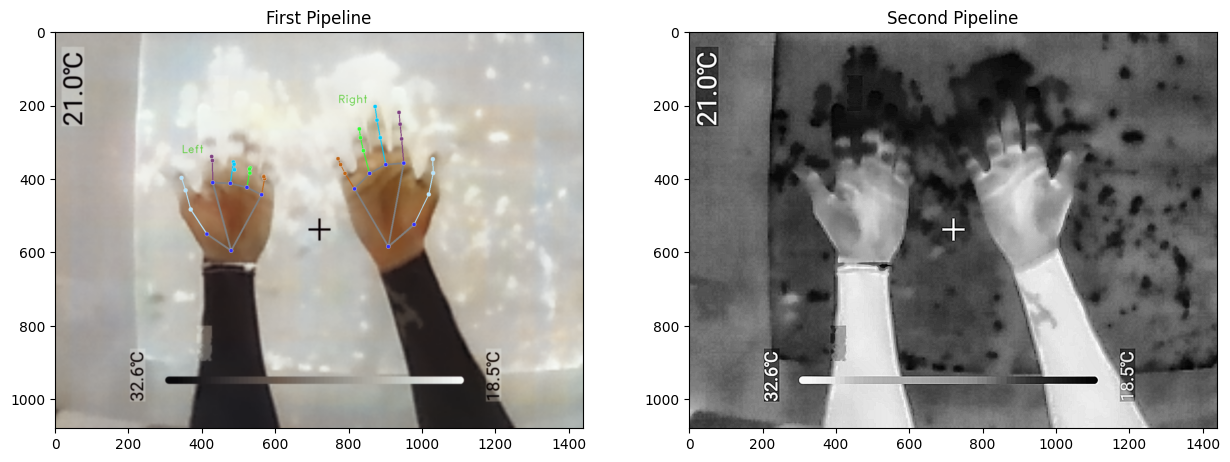

In [80]:
image = cv2.imread(image_59_path)
rotated = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
rotated_path = f"../../resources/stylized-pictures/rotated/{image_59_name}_rotated.png"
cv2.imwrite(rotated_path, rotated)
image_59_path = rotated_path

first_pipeline_image_path = execute_transformation_pipeline(image_59_path, image_59_name)

second_pipeline_image_path = execute_transformation_pipeline_with_no_visible_fingers(image_59_path, image_59_name)

# Predict
image = mp.Image.create_from_file(first_pipeline_image_path)
results = gesture_recognizer.recognize(image)

image_first = cv2.imread(first_pipeline_image_path)
image_first = cv2.cvtColor(image_first, cv2.COLOR_BGR2RGB)

# Draw landmarks
annotated_first = draw_landmarks_on_image(image_first, results)

image = mp.Image.create_from_file(second_pipeline_image_path)
results = gesture_recognizer.recognize(image)

image_second = cv2.imread(second_pipeline_image_path)
image_second = cv2.cvtColor(image_second, cv2.COLOR_BGR2RGB)

annotated_second = draw_landmarks_on_image(image_second, results)

# Plot the images
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(annotated_first)
plt.title("First Pipeline")

plt.subplot(1, 2, 2)
plt.imshow(annotated_second)
plt.title("Second Pipeline")

plt.show()




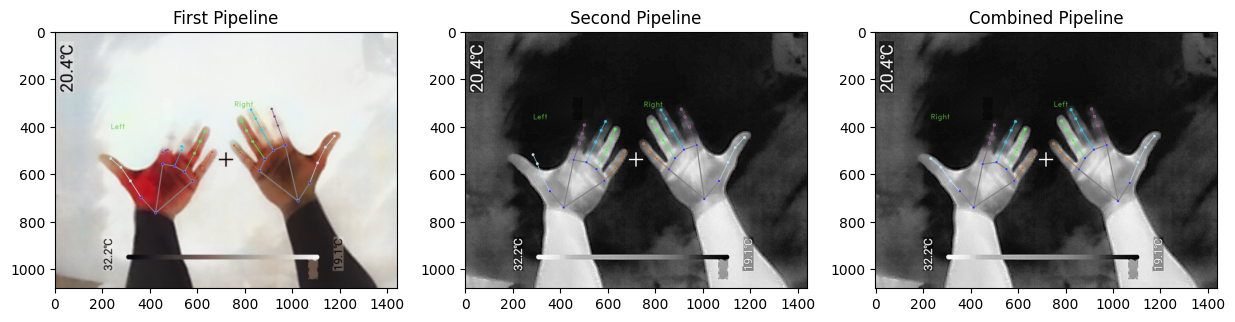

In [84]:
image = cv2.imread(image_66_path)
rotated = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
rotated_path = f"../../resources/stylized-pictures/rotated/{image_66_name}_rotated.png"
cv2.imwrite(rotated_path, rotated)
image_66_path = rotated_path

first_pipeline_image_path = execute_transformation_pipeline(image_66_path, image_66_name)

second_pipeline_image_path = execute_transformation_pipeline_with_no_visible_fingers(image_66_path, image_66_name)

# Predict
image = mp.Image.create_from_file(first_pipeline_image_path)
results1 = gesture_recognizer.recognize(image)

image_first = cv2.imread(first_pipeline_image_path)
image_first = cv2.cvtColor(image_first, cv2.COLOR_BGR2RGB)

# Draw landmarks
annotated_first = draw_landmarks_on_image(image_first, results1)

image = mp.Image.create_from_file(second_pipeline_image_path)
results2 = gesture_recognizer.recognize(image)

image_second = cv2.imread(second_pipeline_image_path)
image_second = cv2.cvtColor(image_second, cv2.COLOR_BGR2RGB)

annotated_second = draw_landmarks_on_image(image_second, results2)

# Combine the landmarks
landmarks_first_right = results1.hand_landmarks[0] if is_right_hand(results1.hand_landmarks[0]) else results1.hand_landmarks[1]
landmarks_first_left = results1.hand_landmarks[0] if not is_right_hand(results1.hand_landmarks[0]) else results1.hand_landmarks[1]

landmarks_second_right = results2.hand_landmarks[0] if is_right_hand(results2.hand_landmarks[0]) else results2.hand_landmarks[1]
landmarks_second_left = results2.hand_landmarks[0] if not is_right_hand(results2.hand_landmarks[0]) else results2.hand_landmarks[1]

merged_landmarks_right = merge_landmarks(landmarks_first_right, landmarks_second_right, 'Right')
merged_landmarks_left = merge_landmarks(landmarks_first_left, landmarks_second_left, 'Left')

results_combined = [merged_landmarks_left, merged_landmarks_right]
handedness = [[Category('Right')], [Category('Left')]]
results_to_draw = Results(results_combined, handedness)


# Draw landmarks
annotated_combined = draw_landmarks_on_image(image_second, results_to_draw)




# Plot annotated images times 3
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow(annotated_first)
plt.title("First Pipeline")

plt.subplot(1, 3, 2)
plt.imshow(annotated_second)
plt.title("Second Pipeline")

plt.subplot(1, 3, 3)
plt.imshow(annotated_combined)
plt.title("Combined Pipeline")

plt.show()

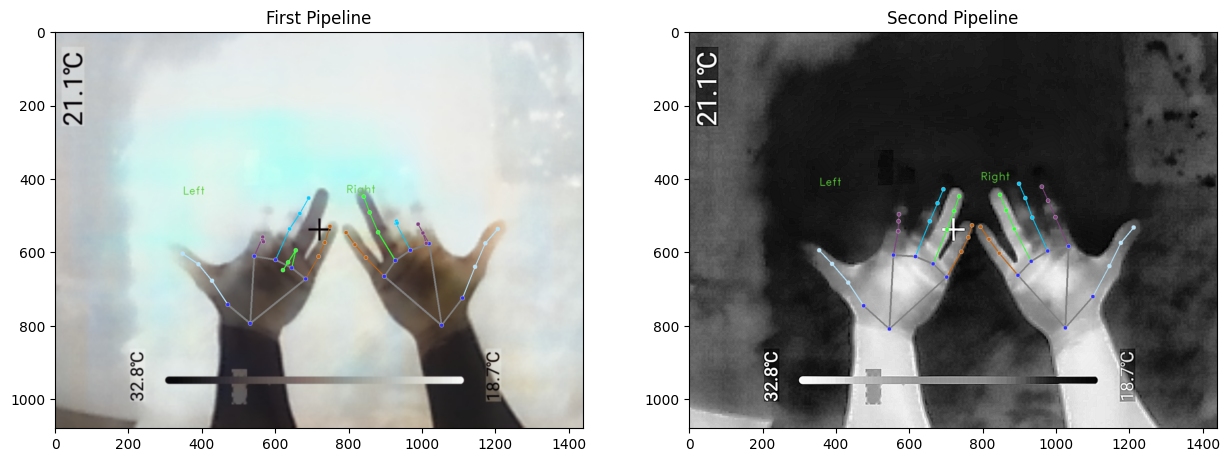

In [67]:
image = cv2.imread(image_68_path)
rotated = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
rotated_path = f"../../resources/stylized-pictures/rotated/{image_68_name}_rotated.png"
cv2.imwrite(rotated_path, rotated)
image_68_path = rotated_path

first_pipeline_image_path = execute_transformation_pipeline(image_68_path, image_68_name)

second_pipeline_image_path = execute_transformation_pipeline_with_no_visible_fingers(image_68_path, image_68_name)

# Predict
image = mp.Image.create_from_file(first_pipeline_image_path)
results = gesture_recognizer.recognize(image)

image_first = cv2.imread(first_pipeline_image_path)
image_first = cv2.cvtColor(image_first, cv2.COLOR_BGR2RGB)

# Draw landmarks
annotated_first = draw_landmarks_on_image(image_first, results)

image = mp.Image.create_from_file(second_pipeline_image_path)
results = gesture_recognizer.recognize(image)

image_second = cv2.imread(second_pipeline_image_path)
image_second = cv2.cvtColor(image_second, cv2.COLOR_BGR2RGB)

annotated_second = draw_landmarks_on_image(image_second, results)

# Plot the images
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(annotated_first)
plt.title("First Pipeline")

plt.subplot(1, 2, 2)
plt.imshow(annotated_second)
plt.title("Second Pipeline")

plt.show()